# **Pre-Process**

In [ ]:
import pandas as pd
import numpy as np
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re

!python -m spacy download en_core_web_lg

nlp = spacy.load('en_core_web_lg')

In [185]:
df = pd.read_csv('bitcoin_sentiments_21_24.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11295 entries, 0 to 11294
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 11295 non-null  object 
 1   Short Description    11295 non-null  object 
 2   Accurate Sentiments  11295 non-null  float64
dtypes: float64(1), object(2)
memory usage: 264.9+ KB


**Remove Stop Words and Lemmatization**

In [91]:
# Set not important word as stop word
irrelevant_words = ['bitcoin', '$', 'price', 'btc', 'market', 'crypto', 'cryptocurrency', 'trade', 'over', 'usd', 's']

# Stop words in spaCy which is important in finance domain
finance_sensitive_words = [
    'down', 'up', 'over', 'under', 'off', 'out', 'back',
    'call', 'put', 'go', 'more', 'less', 'most',
    'few', 'many', 'much', 'below', 'above', 'beyond', 'bottom'
]

# Set new stop words
for new_stop in irrelevant_words:
  nlp.vocab[new_stop].is_stop = True

# Remove stop words
for remove_stop in finance_sensitive_words:
  nlp.vocab[new_stop].is_stop = False

In [92]:
def preprocess_text(text):
  # Remove numbers and symbols
  words_only = re.findall(r'\b[a-zA-Z]+\b', text)
  cleaned_text = ' '.join(words_only)

  doc = nlp(cleaned_text)
  processed_text = []

  # Remove stop word, punctuation and lemmatization
  for token in doc:
    if (token.is_stop or token.is_punct) or (token.lemma_.lower() in irrelevant_words):
      continue
    processed_text.append(token.lemma_.lower())

  return ' '.join(processed_text)

In [93]:
# Preprocess text data and save in new column
df['processed_text'] = df['Short Description'].apply(preprocess_text)

Distribution of Target Class

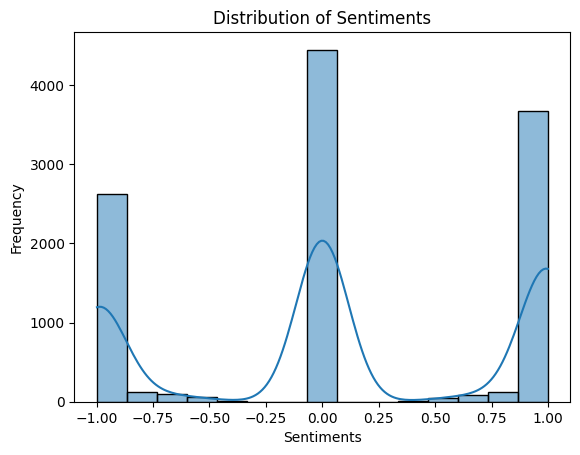

In [186]:
sns.histplot(data = df, x='Accurate Sentiments', kde=True)

plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.show()

In [70]:
# Map sentiment into 3 classes
def map_sentiment(value):
  if value == 0:
    return 0
  elif value > 0:
    return 2
  elif value < 0:
    return 1

In [71]:
df['Sentiment'] = df['Accurate Sentiments'].apply(map_sentiment)

In [95]:
# Count for each class
df.Sentiment.value_counts()

,count
Sentiment,
0,4445
2,3949
1,2901


Imbalanced dataset

Neutral : 0

Negative : 1

Positive : 2

**Text Augmentation**

In [ ]:
!pip install nlpaug

import nlpaug.augmenter.word as naw
import nltk

# Text data augmentation using Synonym Replacement
aug = naw.SynonymAug(aug_src='wordnet')
nltk.download('averaged_perceptron_tagger_eng')

In [97]:
# Randomly picked samples for minority class
label1_df = df[df['Sentiment']==1].sample(n=1544, random_state=42)
label2_df = df[df['Sentiment']==2].sample(n=496, random_state=42)
print(label1_df.Sentiment.value_counts())
print(label2_df.Sentiment.value_counts())

Sentiment
1    1544
Name: count, dtype: int64
Sentiment
2    496
Name: count, dtype: int64


In [98]:
# Augmentation
augmented1_text = label1_df['processed_text'].apply(lambda x: aug.augment(x))
augmented2_text = label2_df['processed_text'].apply(lambda x: aug.augment(x))

augmented1_text = np.stack(augmented1_text)
augmented2_text = np.stack(augmented2_text)

print(len(augmented1_text))
print(len(augmented2_text))

1544
496


In [71]:
#Sample Augmentation
i = 4
print("After Augmentation:", augmented1_text[i])
print("Before Augmentation:", label1_df['processed_text'].iloc[i])

After Augmentation: ['bitvol index fall april mark everyday refuse calendar month low index measure imply volatility derive option price actual choice chassis competition option trader entail volatility represent player view expectation future']
Before Augmentation: bitvol index drop april mark daily decline month low index measure imply volatility derive option price actual option form competition option trader implied volatility represent participant view expectation future


In [99]:
# Combined into one DataFrame
augmented1_df = pd.DataFrame(augmented1_text, columns=['processed_text'])
augmented1_df['Sentiment'] = 1

augmented2_df = pd.DataFrame(augmented2_text, columns=['processed_text'])
augmented2_df['Sentiment'] = 2

concat_df = pd.concat([df[['processed_text','Sentiment']], augmented1_df, augmented2_df])

# Count for each class after augmentation
concat_df.Sentiment.value_counts()

,count
Sentiment,
2,4445
0,4445
1,4445


In [100]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13335 entries, 0 to 495
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   processed_text  13335 non-null  object
 1   Sentiment       13335 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.5+ KB


In [105]:
# Save pre-processed text
# concat_df.to_csv('bitcoin_sentiments_processed.csv', index=False)

# **EDA**

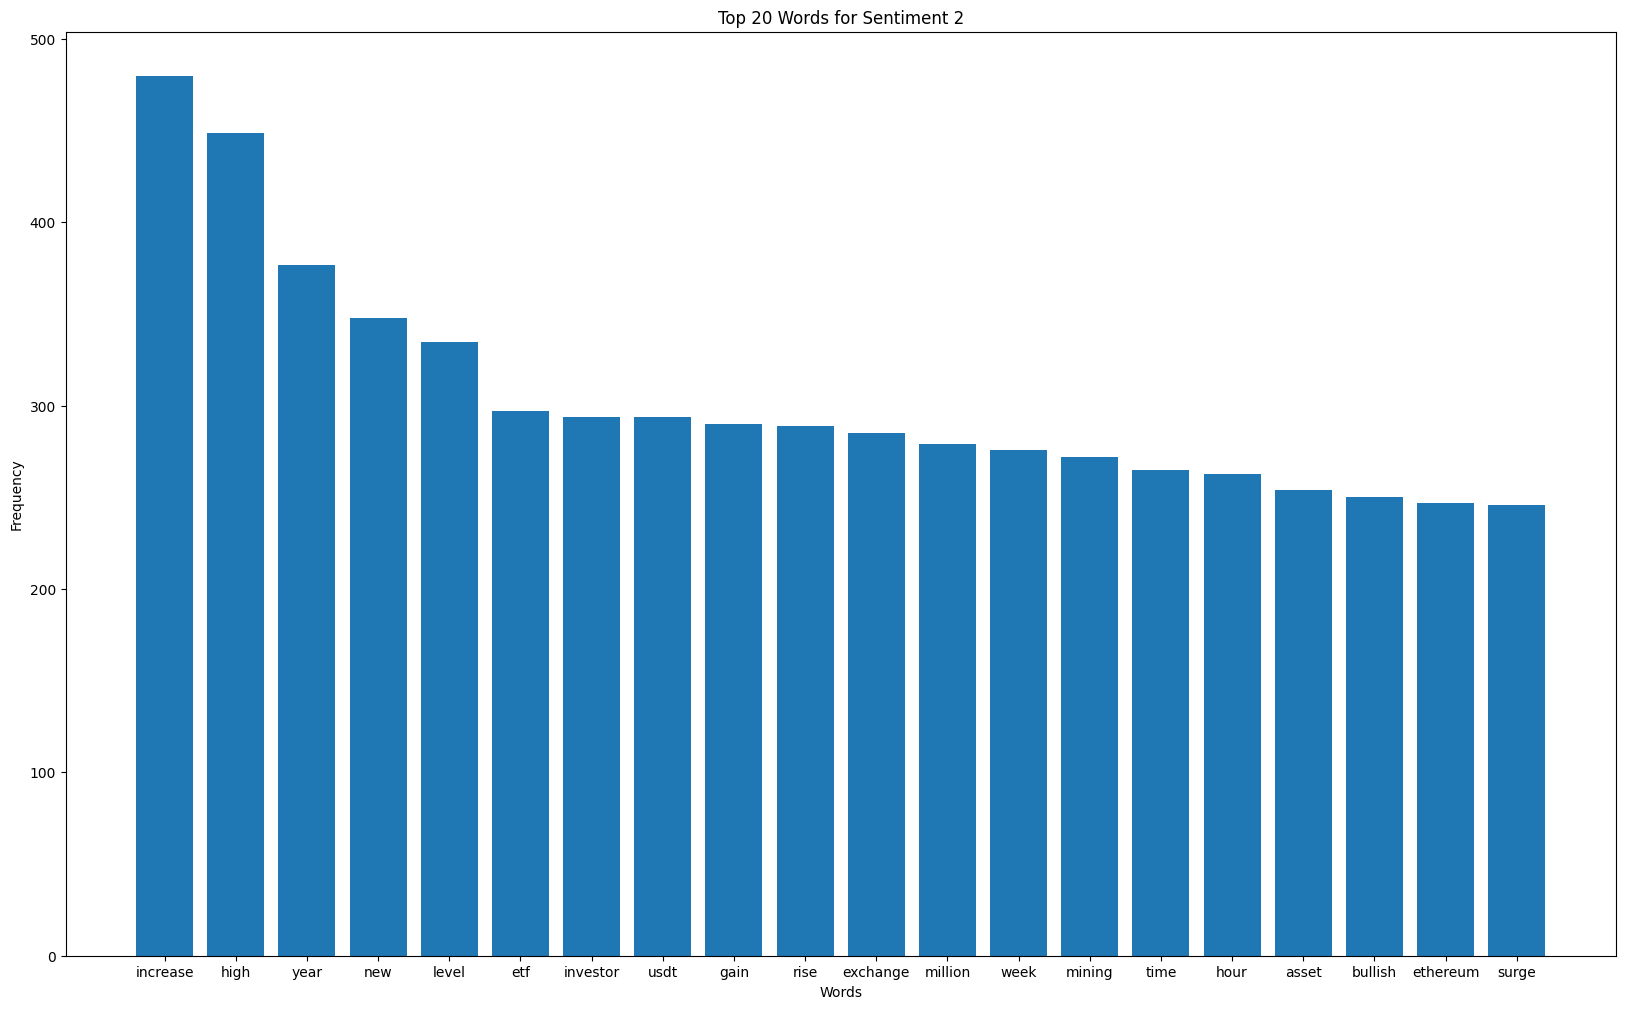

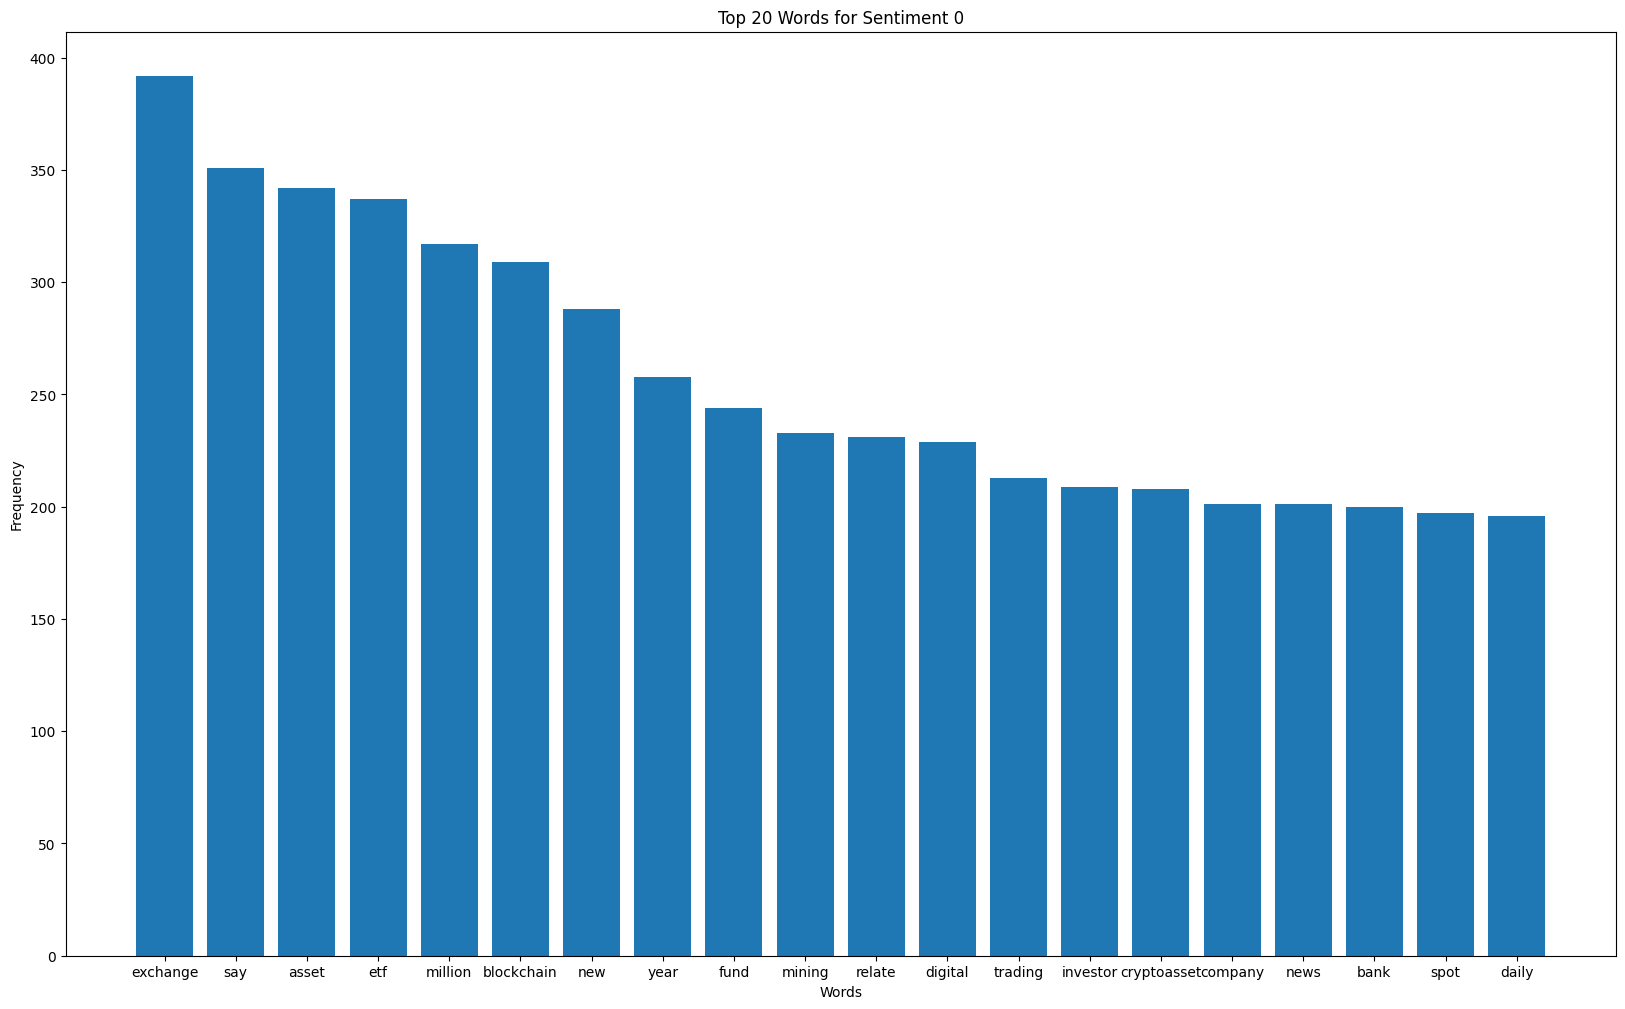

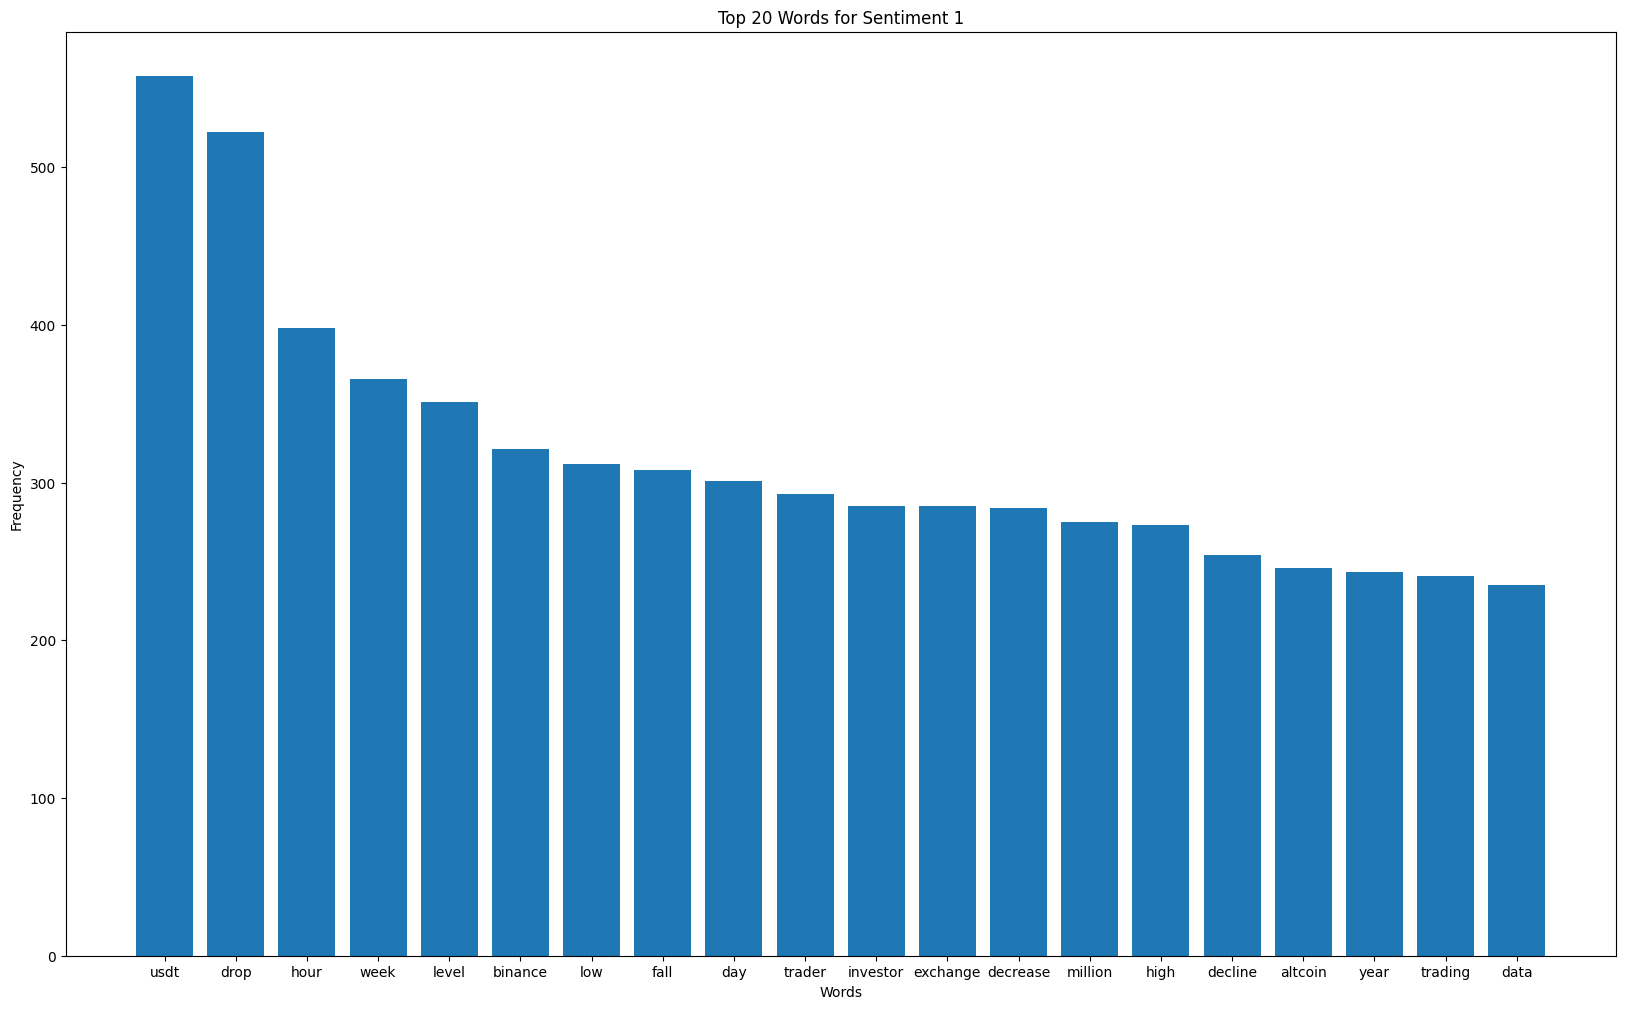

In [115]:
# Count of words in each class
from collections import Counter

sentiment_word_count = {}

for sentiment in concat_df['Sentiment'].unique():
  all_words = ' '.join(concat_df[concat_df['Sentiment']==sentiment]['processed_text']).split()
  word_count = Counter(all_words)
  sentiment_word_count[sentiment] = word_count

for sentiment, counter in sentiment_word_count.items():
  top_words = counter.most_common(20)
  words, counts = zip(*top_words)

  plt.figure(figsize=(20, 12))
  plt.bar(words, counts)
  plt.xlabel('Words')
  plt.ylabel('Frequency')
  plt.title(f'Top 20 Words for Sentiment {sentiment}')

In [165]:
# Pick important features using chi2 test
vectorizer = CountVectorizer(ngram_range=(1,2), min_df=2) #bigram
X = vectorizer.fit_transform(concat_df.processed_text)
feature_names = vectorizer.get_feature_names_out()

# Perform Chi-square test
chi2_scores, p_values = chi2(X, concat_df.Sentiment)

# Put results in a DataFrame
chi2_df = pd.DataFrame({
    'feature': feature_names,
    'chi2_score': chi2_scores,
    'p_value': p_values
}).sort_values(by='chi2_score', ascending=False)

/tmp/ipython-input-598456130.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


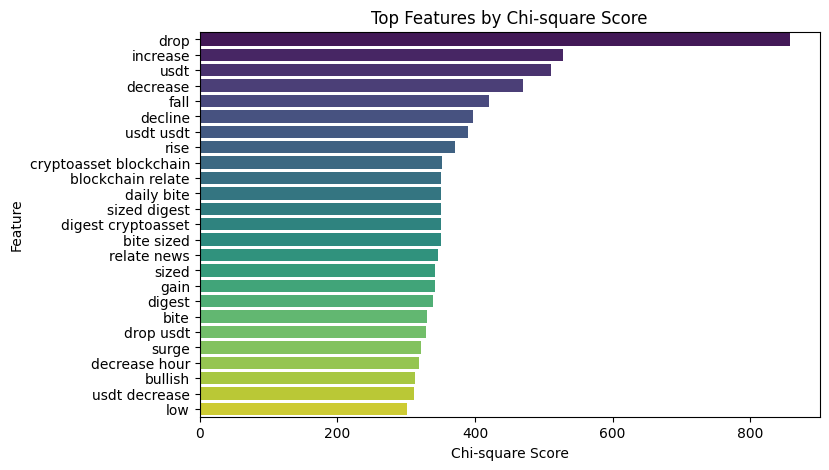

/tmp/ipython-input-598456130.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


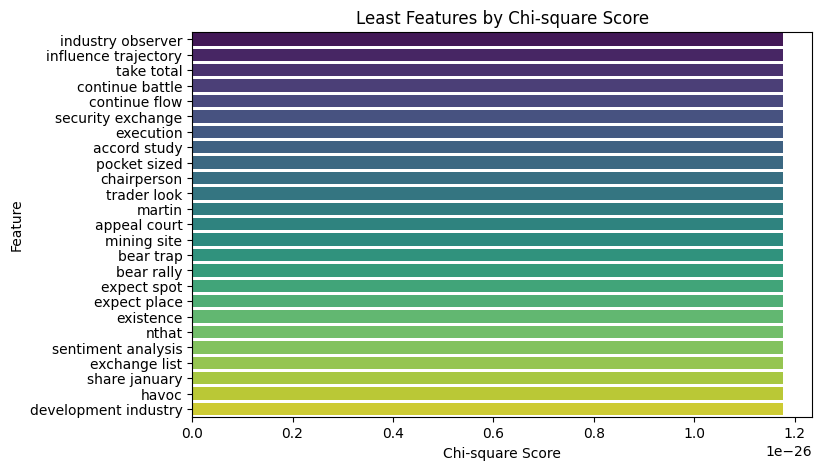

In [166]:
# Top and Last 25 important words
n = 25
plt.figure(figsize=(8, 5))
sns.barplot(
    x='chi2_score',
    y='feature',
    data=chi2_df.head(n),
    palette='viridis'
)
plt.title("Top Features by Chi-square Score")
plt.xlabel("Chi-square Score")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(
    x='chi2_score',
    y='feature',
    data=chi2_df.tail(n),
    palette='viridis'
)
plt.title("Least Features by Chi-square Score")
plt.xlabel("Chi-square Score")
plt.ylabel("Feature")
plt.show()


In [172]:
y = concat_df.Sentiment

# Pick top 2000 words for ML model
selector = SelectKBest(chi2, k=2000)
X_new = selector.fit_transform(X, y)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# **Machine Learning Model**

**Naive Bayes Model**

Training Accuracy: 0.7468128983877015
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.80      0.74       892
           1       0.76      0.66      0.71       880
           2       0.71      0.67      0.69       895

    accuracy                           0.71      2667
   macro avg       0.71      0.71      0.71      2667
weighted avg       0.71      0.71      0.71      2667



<Axes: >

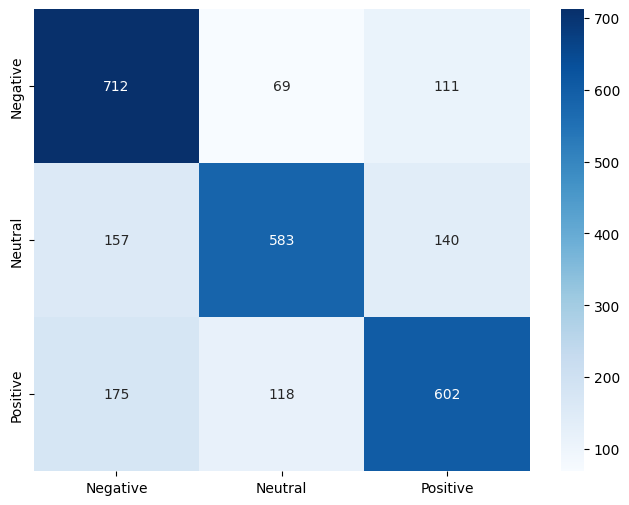

In [176]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print("Training Accuracy:", nb.score(X_train, y_train))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

**Random Forest Model**

Training Accuracy: 0.9985939257592801
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       892
           1       0.75      0.77      0.76       880
           2       0.75      0.66      0.70       895

    accuracy                           0.73      2667
   macro avg       0.74      0.73      0.73      2667
weighted avg       0.74      0.73      0.73      2667



<Axes: >

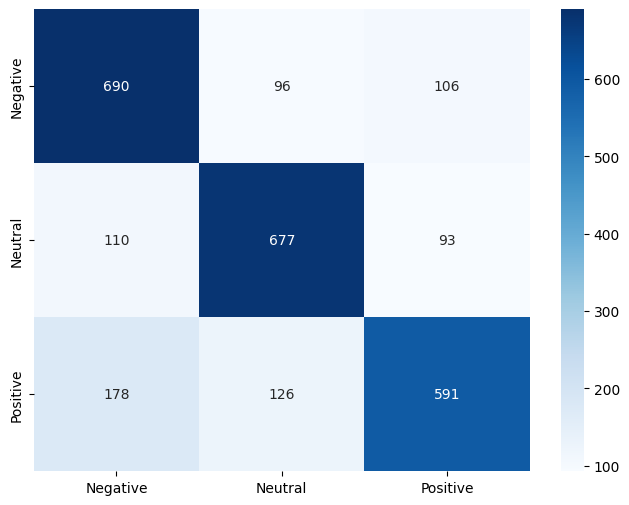

In [175]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Training Accuracy:", rf.score(X_train, y_train))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

**Gradient Boosting Model**

Training Accuracy: 0.7058492688413949
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.89      0.70       892
           1       0.78      0.53      0.63       880
           2       0.74      0.57      0.64       895

    accuracy                           0.66      2667
   macro avg       0.70      0.66      0.66      2667
weighted avg       0.70      0.66      0.66      2667



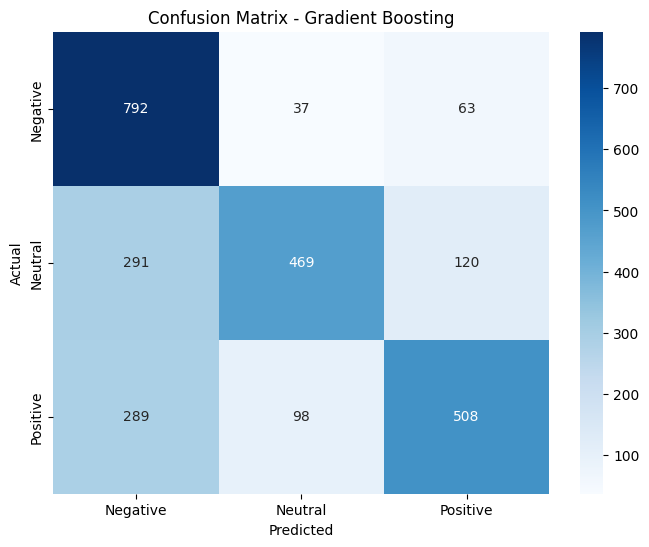

In [177]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Predictions
y_pred = gb.predict(X_test)

# Training accuracy
print("Training Accuracy:", gb.score(X_train, y_train))

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Negative', 'Neutral', 'Positive'],
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

# **HF Embedding Model Pretrained with Finance Data**

**Embedding wiht Pre-Processed Text**

In [138]:
from sentence_transformers import SentenceTransformer

# Download from the 🤗 Hub
model = SentenceTransformer("sujet-ai/Marsilia-Embeddings-EN-Base")

In [139]:
# Embedding
def embed(text):
  return model.encode(text)

In [143]:
concat_df['vector'] = concat_df['processed_text'].apply(embed)
concat_df.head()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,processed_text,Sentiment,vector
0,consolidate near support ethereum hold gain xr...,2,"[-0.013434091, -0.009089007, 0.028309677, 0.00..."
1,congress finally approve reject malign infrast...,0,"[-0.005249755, -0.023931362, -0.014571884, 0.0..."
2,increasingly political instrument decision mak...,0,"[0.026665071, -0.023303537, 0.030158192, 0.035..."
3,potential rise cycle ethereum face tough compe...,2,"[0.0008454564, -0.01695327, -0.01809442, 0.048..."
4,company look latin america set create new basi...,0,"[0.028907742, -0.002767521, -0.026061002, 0.02..."


In [161]:
X_train, X_test, y_train, y_test = train_test_split(concat_df['vector'], concat_df['Sentiment'], test_size=0.2, random_state=42)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

Training Accuracy: 0.6693850768653918
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.75      0.68       892
           1       0.69      0.63      0.66       880
           2       0.67      0.58      0.62       895

    accuracy                           0.66      2667
   macro avg       0.66      0.66      0.65      2667
weighted avg       0.66      0.66      0.65      2667



<Axes: >

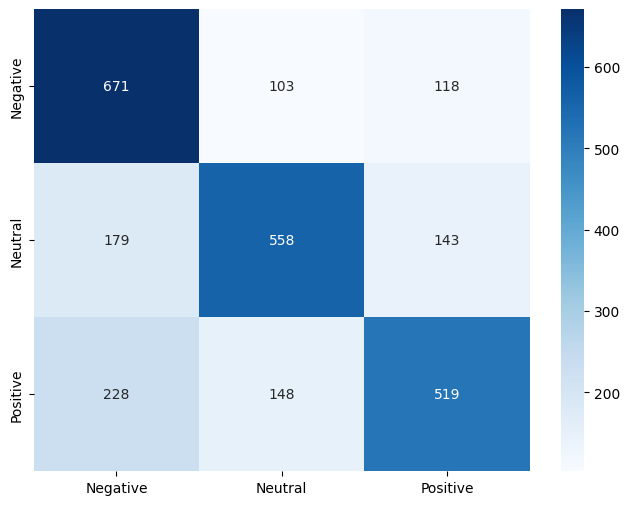

In [164]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

nb = MultinomialNB()
nb.fit(X_train_2d, y_train)

y_pred = nb.predict(X_test_2d)

print("Training Accuracy:", nb.score(X_train_2d, y_train))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])

**Embedding with Original**

In [ ]:
df = pd.read_csv('bitcoin_sentiments_21_24.csv')
# df.head()

In [ ]:
df['Sentiment'] = df['Accurate Sentiments'].apply(map_sentiment)
# df.head()

In [ ]:
df['vector'] = df['Short Description'].apply(embed)
# df.head()

In [183]:
X_train, X_test, y_train, y_test = train_test_split(df['vector'], df['Sentiment'], test_size=0.2, random_state=42)

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

Training Accuracy: 0.6687693669765383
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.72       922
           1       0.77      0.52      0.62       578
           2       0.65      0.65      0.65       759

    accuracy                           0.68      2259
   macro avg       0.69      0.66      0.67      2259
weighted avg       0.69      0.68      0.67      2259



<Axes: >

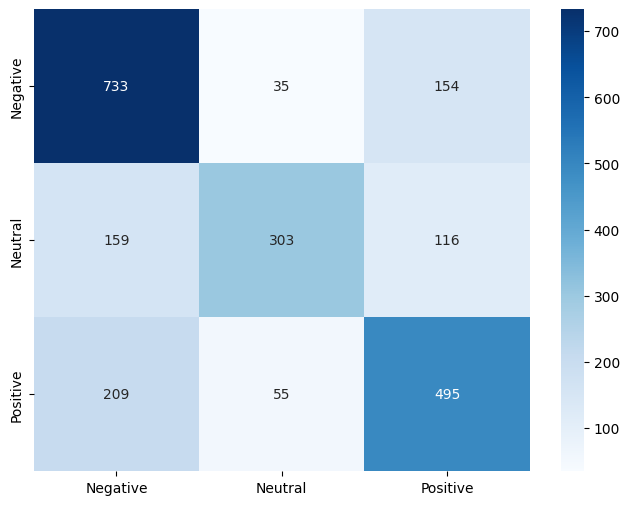

In [184]:
scaler = MinMaxScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

nb = MultinomialNB()
nb.fit(X_train_2d, y_train)

y_pred = nb.predict(X_test_2d)

print("Training Accuracy:", nb.score(X_train_2d, y_train))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])